<a href="https://colab.research.google.com/github/stvnfrnk/CoLab_franke/blob/main/get_S2_L8_chlorophyl_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acquire Sentinel2/Landsat8 data for a certain location and plot chlorophyl concentrations

### start earth engine


In [ ]:
import ee

ee.Authenticate()
ee.Initialize()

### define region, bands, max. cloud coverage and create image collection

Here we:
1. define a region where to search for
2. define a rectangle to clip the data afterwards
3. define the bands we want to use
4. create an image collection for Sentinel-2 / Landsat 8
5. apply some filters to that collection:
  - location
  - time period
  - max. cloud coverage (if possible)
6. print the dates of the satelite scenes to get an overview of the image collection

In [ ]:
# 1 #
region = '_gili_coast'

# a point coordinate which the satelite scene should cover
P_gili = ee.Geometry.Point(116.03605487730204,-8.349692403728154)

# 2 #
# a rectangle to clip the large satelite scenes afterwards
R_gili_large = ee.Geometry.Polygon([
                                    [
                                    [116.00489833738504,-8.385612290198798],
                                    [116.07442119505106,-8.385612290198798],
                                    [116.07442119505106,-8.311221342583268],
                                    [116.00489833738504,-8.311221342583268],
                                    [116.00489833738504,-8.385612290198798]
                                    ]
                                   ]);
# 3 #
# Band names (B2=blue, B3=green, B4=red)
Bands = ['B2', 'B3', 'B4']

# define location and region for next step
loc = P_gili
reg = R_gili_large

# 4, 5 #
# acquire image collection
# Sentinel-2 (if 1 = runs the code, if 0 doesn't run this block)
if 0:
  collection_S2 = ee.ImageCollection('COPERNICUS/S2_SR') \    # entire collection
      .filterBounds(loc) \                                    # filter by location
      .filterDate('2019-01-01', '2020-11-01') \               # filter by time period
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30)) \   # filter by cloud cover (this is the cloud cover for the whole scene and not for the clipped region)
      .select(Bands)                                          # select the three bands defined before (reduces file size
      )
  # 6 #
  # get the dates
  dates = collection_S2.aggregate_array('system:time_start').map(lambda time_start: ee.Date(time_start).format('Y-MM-dd_hh_mm')).getInfo()
  
  # print the dates to get an overview
  for date in sorted(dates):
    print(date)

# 4, 5 #
# acquire image collection
# Landsat 8:
if 1:
  collection_L8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \  # entire collection
      .filterBounds(loc) \                                        # filter by location
      .filterDate('2019-01-01', '2020-11-01') \                   # filter by time period
      .select(Bands)                                              # select bands

  # 6 #
  # get the dates
  dates = collection_L8.aggregate_array('system:time_start').map(lambda time_start: ee.Date(time_start).format('Y-MM-dd_hh_mm')).getInfo()

  # get the dates
  for date in sorted(dates):
    print(date)

### submit jobs to collect single images

Now we have an image collection and neet to download it from google:
1. we create a list of the single images in the collection
2. a loop will export every image to our google drive
3. at this point we clip every image to the desired region
4. we give each image a name with a prefix (e.g. S2_SR for Sentinel-2 Surface Reflectance) + the date + the region)
5. ee.batch.Export.image.toDrive will do that

In [ ]:
# For Sentinel 2
# This is OK for small collections

# create a List to loop over
collectionList = collection_S2.toList(collection_S2.size())
collectionSize = collectionList.size().getInfo()

for i in range(collectionSize):
    ee.batch.Export.image.toDrive(
        image = ee.Image(collectionList.get(i)).clip(reg),
        fileNamePrefix = 'S2_SR_' + dates[i] + region).start()
    
    print('Starting Task: S2_SR_{}_{}'.format(dates[i], region))

In [ ]:
# For Landsat 8
# This is OK for small collections
collectionList = collection_L8.toList(collection_L8.size())
collectionSize = collectionList.size().getInfo()

for i in range(collectionSize):
    ee.batch.Export.image.toDrive(
        image = ee.Image(collectionList.get(i)).clip(reg),
        fileNamePrefix = 'L8_' + dates[i] + region).start()
    
    print('Starting Task: L8_SR_{}_{}'.format(dates[i], region))

## Process the Data

The data is now in our google drive and we can work with the Geotifs. This can be done here or you can download the data and do that on your own computer.
My workflow is the following:

1. I install some particular packages i might need, which are not installed already in this CoLab environment

In [ ]:
!pip install rasterio
!pip install geopandas
#!pip install fiona

2. I import some more packages...
3. --> !! I need to mount the google drive to have access to the satelite images

In [ ]:
import numpy as np
import pandas as pd
import fiona
import rasterio
import rasterio.mask
from rasterio.plot import show
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib import collections as cplt
from matplotlib import gridspec
import rasterio.plot
from descartes import PolygonPatch

import os, glob

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### calculate chlorophyl concentrations

1. set the path to your personal drive, which is '/content/drive/MyDrive/'
2. we create a list containing all files with glob.glob
3. we open the geotif with the rasterio package

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


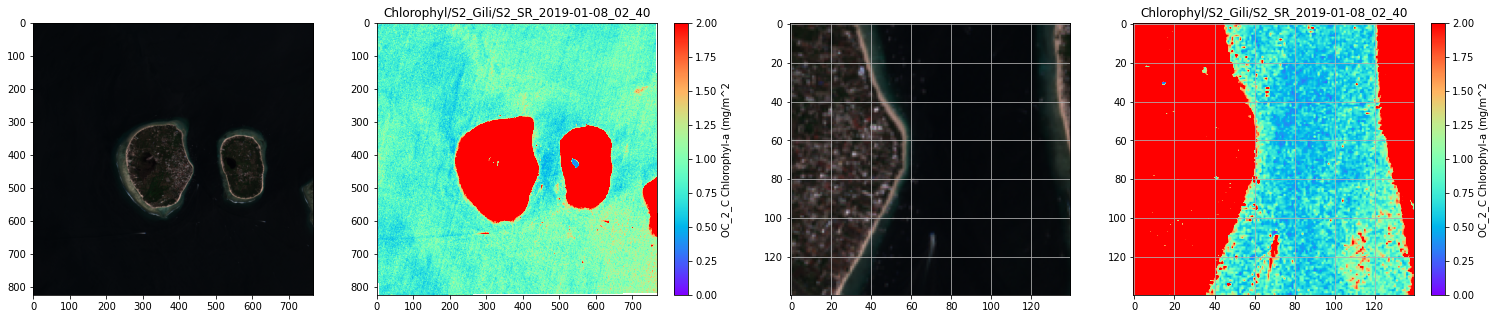

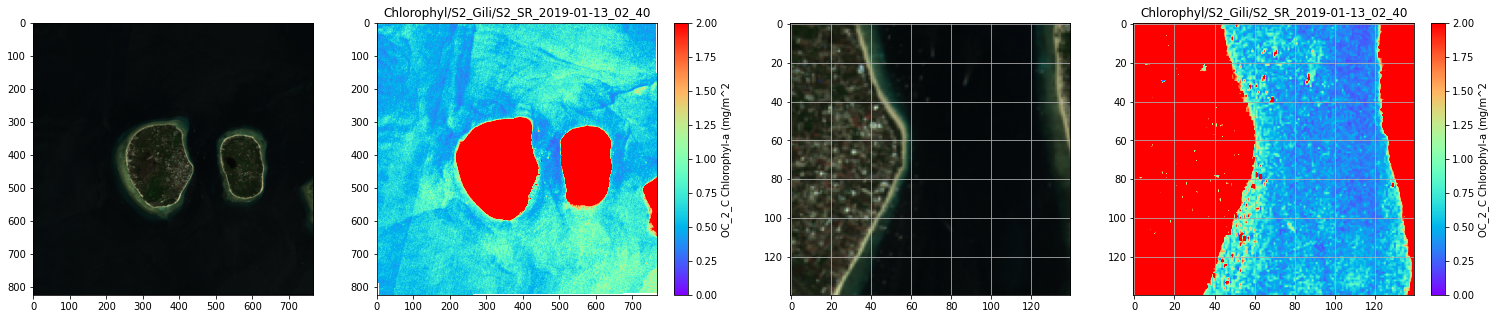

In [ ]:
path = '/content/drive/MyDrive/Chlorophyl/S2_Gili/'
files = sorted(glob.glob(path + 'S2_SR_*.tif'))[0:2]

for file in files:                             #'S2_SR_2019-04-18_02_40_gili_coast.tif'

  src = rasterio.open(file)
  rx = xr.open_rasterio(file)

  filename = file.split('/content/drive/MyDrive/')[-1].split('_gili_coast.tif')[0]

  scale = 0.0001

  Rrs_490 = src.read(1) * scale
  Rrs_555 = src.read(2) * scale

  a0 = 0.341 
  a1 = -3.0010 
  a2 = 2.811 
  a3 = -2.041
  a4 = 0.0400

  R        = np.log(Rrs_490/Rrs_555)
  exponent = a0 + (a1 * R) +(a2 * R**2) + (a3 * R**3)

  OC_2_C = 10**(exponent) + a4 


  # Normalize bands into 0.0 - 1.0 scale
  def normalize(array):
      array_min, array_max = array.min(), array.max()
      return (array - array_min) / (array_max - array_min)

  # Convert to numpy arrays
  blue  = src.read(1) * scale
  green = src.read(2) * scale
  red   = src.read(3) * scale

  # Normalize band DN
  blue  = normalize(blue)
  green = normalize(green)
  red   = normalize(red)

  # Stack bands
  rgb = np.dstack((red, green, blue))

  #rgb = pd.DataFrame(rgb)
  OC_2_C = pd.DataFrame(OC_2_C)

  rgb_clip    = np.dstack((red[380:520].T[380:520].T, green[380:520].T[380:520].T, blue[380:520].T[380:520].T))
  OC_2_C_clip = OC_2_C[380:520].T[380:520].T
  
  cmap='rainbow'

  fig = plt.subplots(figsize=(26, 5))
  gs  = gridspec.GridSpec(1, 4,
                      width_ratios=[8, 10, 8, 10],
                      height_ratios=[1]
              )
  
  ax0 = plt.subplot(gs[0])
  ax0.imshow(rgb, aspect='auto')

  ax1 = plt.subplot(gs[1])
  img = ax1.imshow(OC_2_C, aspect='auto', vmin=0, vmax=2, cmap=cmap)
  plt.title(filename)
  cbar = plt.colorbar(mappable=img)
  cbar.set_label('OC_2_C Chlorophyl-a (mg/m^2')

  ax2 = plt.subplot(gs[2])
  ax2.imshow(rgb_clip, aspect='auto')
  plt.grid()

  ax3 = plt.subplot(gs[3])
  img = ax3.imshow(OC_2_C_clip, aspect='auto', vmin=0, vmax=2, cmap=cmap)
  plt.grid()
  plt.title(filename)
  cbar = plt.colorbar(mappable=img)
  cbar.set_label('OC_2_C Chlorophyl-a (mg/m^2')
  #plt.savefig('/content/drive/MyDrive/' + 'plot_' + filename + '.png', dpi=200, bbox_inches='tight')
  plt.show()

In [ ]:
ls /content/drive/MyDrive/Chlorophyl/S2_Gili

### calculate monthly means

In [ ]:
blblb

## plotting

In [ ]:
filename

'S2_SR_2019-01-13_02_40'

### Landsat 8

In [ ]:
path = '/content/drive/MyDrive/'
files = sorted(glob.glob(path + 'L8_*.tif'))[0:-1]

for file in files:                             #'S2_SR_2019-04-18_02_40_gili_coast.tif'

  src = rasterio.open(file)
  rx = xr.open_rasterio(file)

  filename = file.split('/content/drive/MyDrive/')[-1].split('_gili_coast.tif')[0]

  scale = 0.0001

  Rrs_490 = src.read(1) * scale
  Rrs_555 = src.read(2) * scale

  a0 = 0.341 
  a1 = -3.0010 
  a2 = 2.811 
  a3 = -2.041
  a4 = 0.0400

  R        = np.log(Rrs_490/Rrs_555)
  exponent = a0 + (a1 * R) +(a2 * R**2) + (a3 * R**3)

  OC_2_C = 10**(exponent) + a4 


  # Normalize bands into 0.0 - 1.0 scale
  def normalize(array):
      array_min, array_max = array.min(), array.max()
      return (array - array_min) / (array_max - array_min)

  # Convert to numpy arrays
  blue  = src.read(1) * scale
  green = src.read(2) * scale
  red   = src.read(3) * scale

  # Normalize band DN
  blue  = normalize(blue)
  green = normalize(green)
  red   = normalize(red)

  # Stack bands
  rgb = np.dstack((red, green, blue))

  #rgb = pd.DataFrame(rgb)
  OC_2_C = pd.DataFrame(OC_2_C)

  rgb_clip    = np.dstack((red[380:520].T[380:520].T, green[380:520].T[380:520].T, blue[380:520].T[380:520].T))
  OC_2_C_clip = OC_2_C[380:520].T[380:520].T

  # View the color composite
  
  cmap='rainbow'

  fig = plt.subplots(figsize=(26, 5))
  gs  = gridspec.GridSpec(1, 4,
                       width_ratios=[8, 10, 8, 10],
                       height_ratios=[1]
               )
  
  ax0 = plt.subplot(gs[0])
  ax0.imshow(rgb, aspect='auto')

  ax1 = plt.subplot(gs[1])
  img = ax1.imshow(OC_2_C, aspect='auto', vmin=0, vmax=2, cmap=cmap)
  plt.title(filename)
  cbar = plt.colorbar(mappable=img)
  cbar.set_label('OC_2_C Chlorophyl-a (mg/m^2')

  ax2 = plt.subplot(gs[2])
  ax2.imshow(rgb_clip, aspect='auto')
  plt.grid()

  ax3 = plt.subplot(gs[3])
  img = ax3.imshow(OC_2_C_clip, aspect='auto', vmin=0, vmax=2, cmap=cmap)
  plt.grid()
  plt.title(filename)
  cbar = plt.colorbar(mappable=img)
  cbar.set_label('OC_2_C Chlorophyl-a (mg/m^2')
  plt.savefig('/content/drive/MyDrive/' + 'plot_' + filename + '.png', dpi=200, bbox_inches='tight')
  plt.show()